In [4]:
import ee
ee.Authenticate()
ee.Initialize()


Enter verification code:  4/1AUJR-x7ym-2l_YO_2oFn2APVIvbmjUYznJpNYyM-pfOlfE53S1Pa3QDVYH4



Successfully saved authorization token.


US states shapefile loaded successfully.
Texas geometry extracted.
US counties shapefile loaded successfully.
Texas counties extracted.
Texas geometry converted to Earth Engine format.
Number of VIIRS images between 2021-02-01 and 2021-02-13: 12
Number of VIIRS images between 2021-02-14 and 2021-02-20: 6
Pre-Event Radiance p2: 1.0085996266559794, p98: 19.719882949569218
Difference Radiance range: [-1.4062512394057713, 1.4062512394057713]


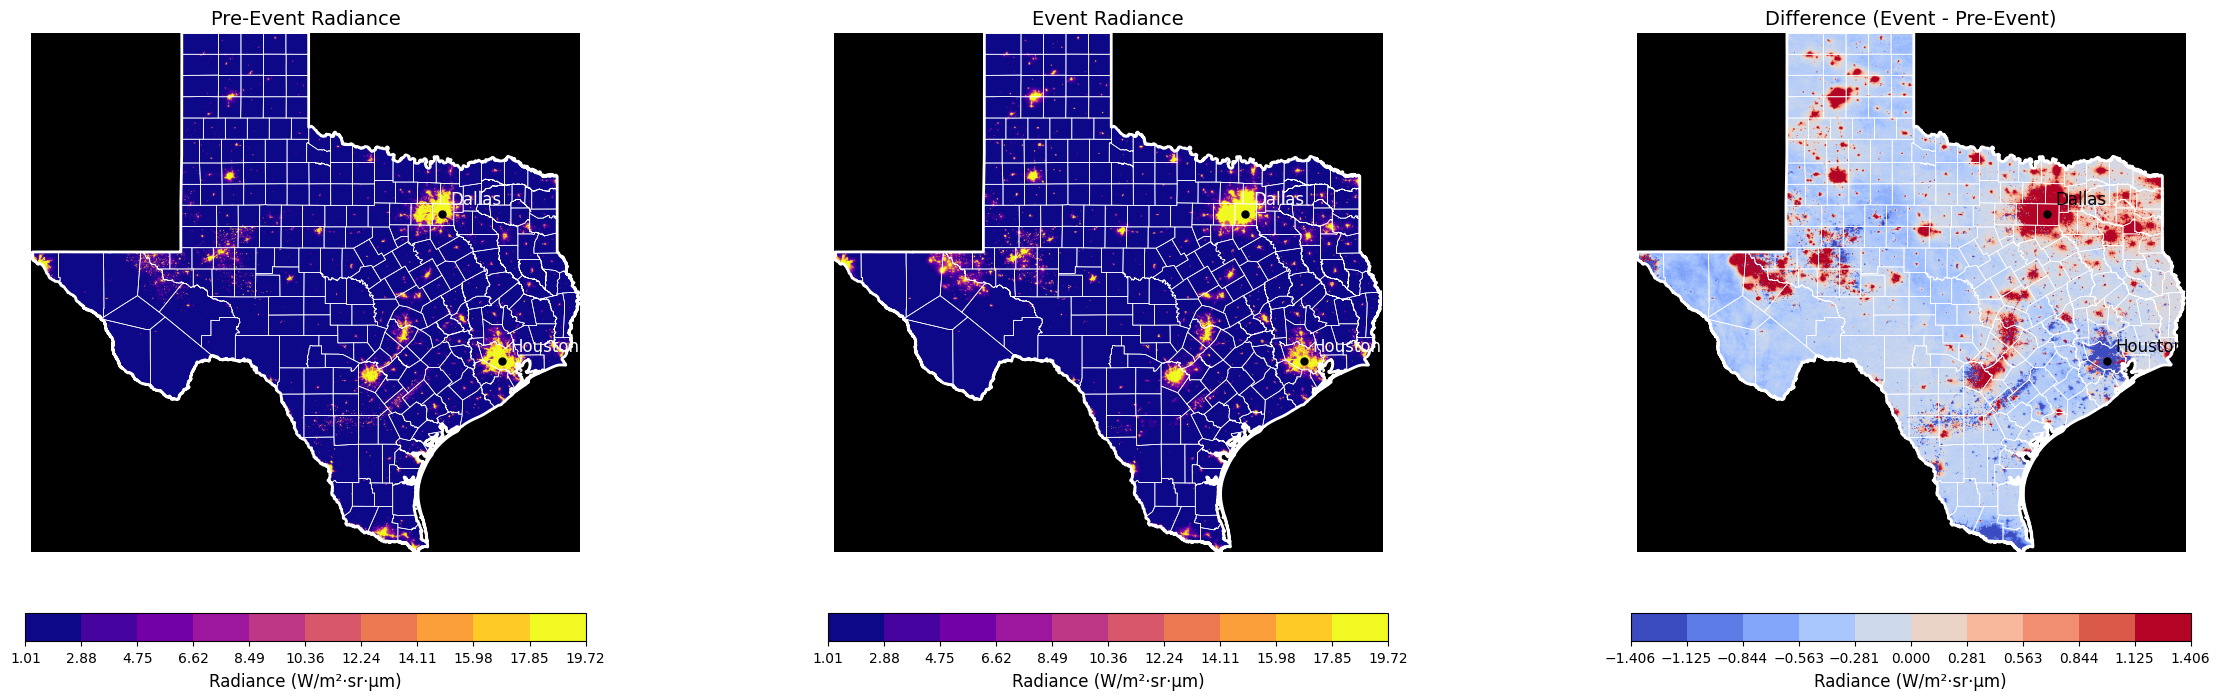

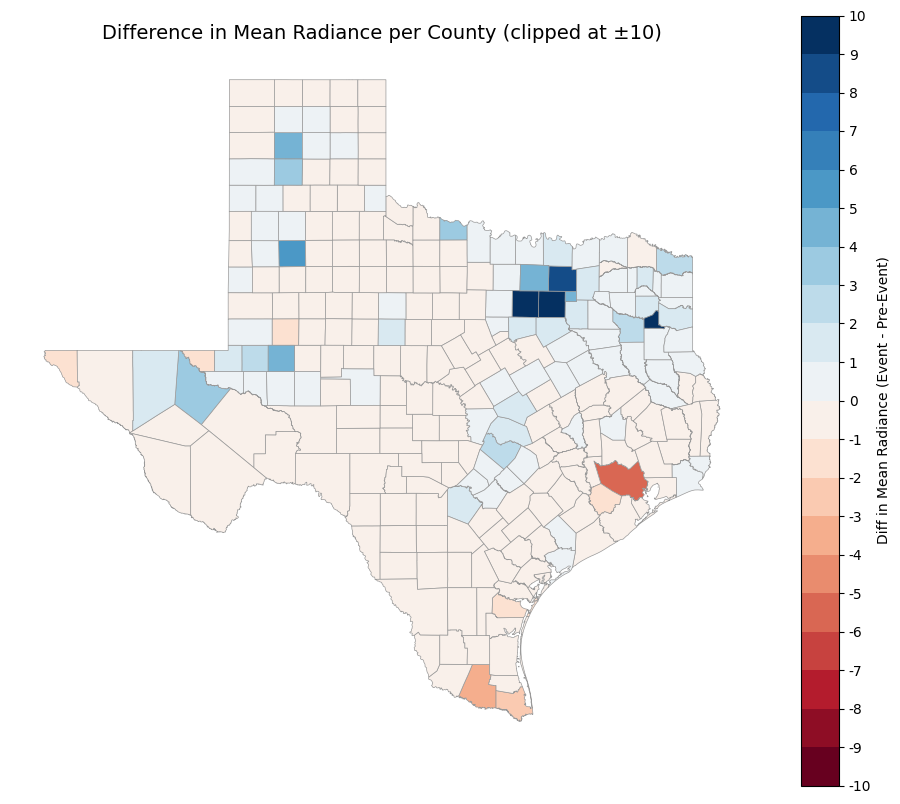

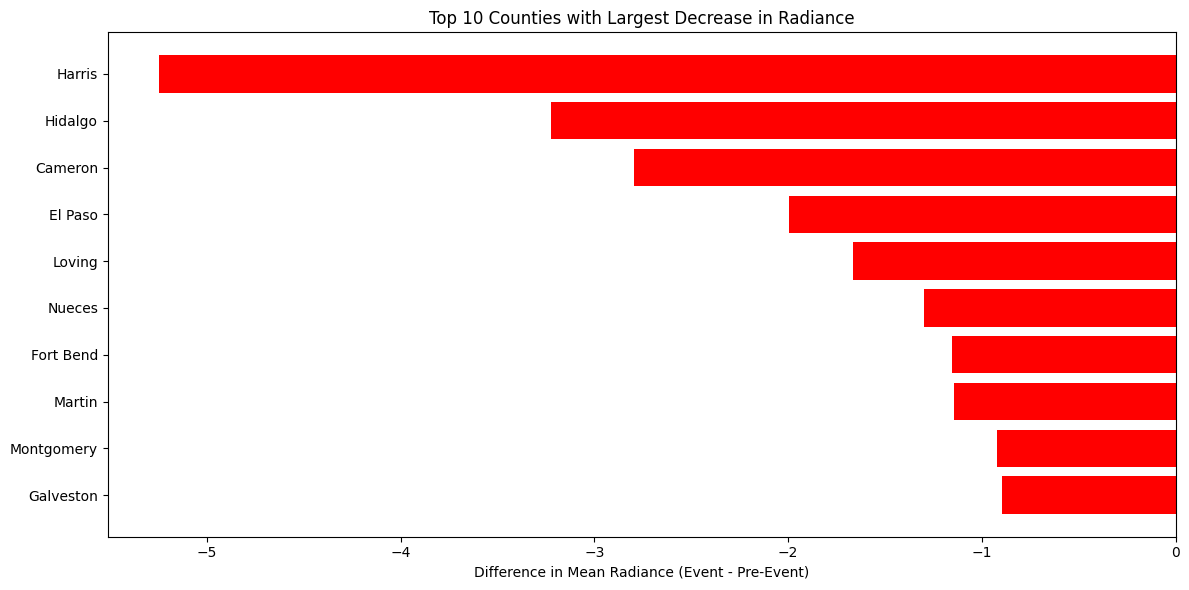

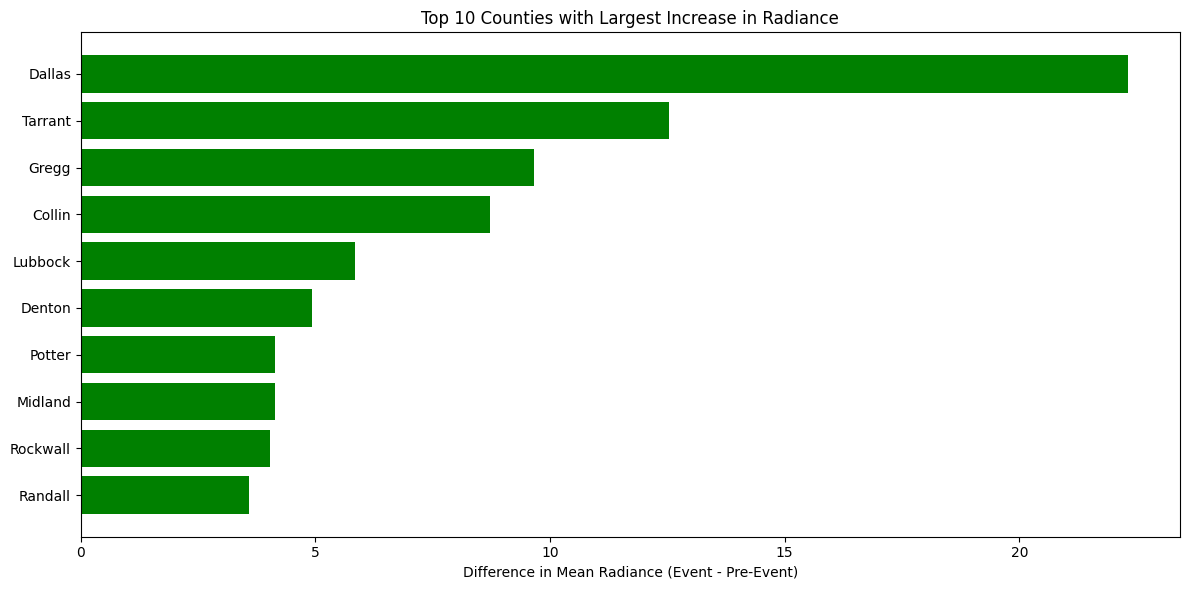

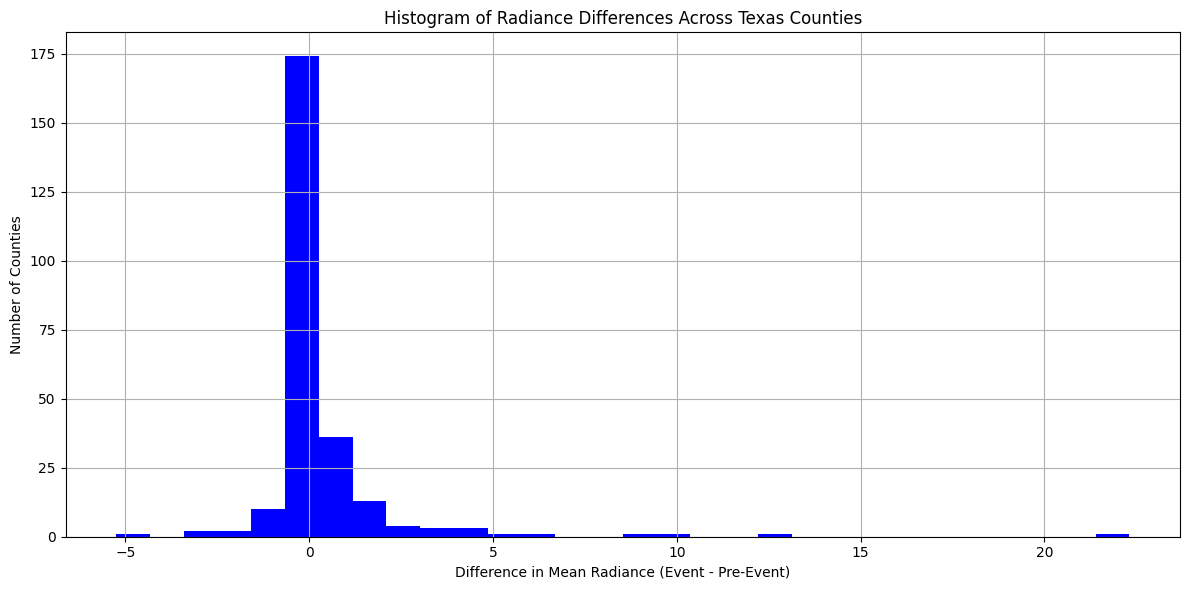

In [5]:
# -------------------------------------------------
# 0. Import and Initialize
# -------------------------------------------------

import ee
import geopandas as gpd
import pandas as pd
import requests
import io

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

# Initialize Earth Engine
ee.Initialize()

# -------------------------------------------------
# 1. Load Texas Geometry
# -------------------------------------------------
def load_texas_geometry():
    # Load US states shapefile from the Census Bureau
    url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip'
    states_gdf = gpd.read_file(url)
    print("US states shapefile loaded successfully.")

    # Filter for Texas (STATEFP == '48')
    texas = states_gdf[states_gdf['STATEFP'] == '48']
    if texas.empty:
        raise ValueError("Texas not found in the shapefile.")
    print("Texas geometry extracted.")
    return texas

def load_texas_counties():
    # Load US counties shapefile
    url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_500k.zip'
    counties_gdf = gpd.read_file(url)
    print("US counties shapefile loaded successfully.")

    # Filter for Texas counties (STATEFP == '48')
    texas_counties = counties_gdf[counties_gdf['STATEFP'] == '48']
    print("Texas counties extracted.")
    return texas_counties

texas_gdf = load_texas_geometry()
texas_counties_gdf = load_texas_counties()

# -------------------------------------------------
# 2. Convert Texas Geometry to Earth Engine Geometry
# -------------------------------------------------
def get_texas_geometry(texas_gdf):
    """Convert a GeoDataFrame row (Texas) to an Earth Engine geometry."""
    texas_shape = texas_gdf.geometry.iloc[0]
    texas_coordinates = texas_shape.__geo_interface__['coordinates']
    geometry_type = texas_shape.geom_type

    if geometry_type == 'Polygon':
        texas_geometry = ee.Geometry.Polygon(texas_coordinates)
    elif geometry_type == 'MultiPolygon':
        polygons = []
        for polygon_coords in texas_coordinates:
            polygons.append(ee.Geometry.Polygon(polygon_coords))
        texas_geometry = ee.Geometry.MultiPolygon(polygons)
    else:
        raise ValueError(f"Unsupported geometry type: {geometry_type}")

    print("Texas geometry converted to Earth Engine format.")
    return texas_geometry

aoi = get_texas_geometry(texas_gdf)

# -------------------------------------------------
# 3. Define Date Ranges
# -------------------------------------------------
pre_event_start = '2021-02-01'
pre_event_end   = '2021-02-13'
event_start     = '2021-02-14'
event_end       = '2021-02-20'

# -------------------------------------------------
# 4. Load and Process VIIRS Data
# -------------------------------------------------
viirs_dataset = ee.ImageCollection('NOAA/VIIRS/001/VNP46A1')

def mask_clouds(image):
    """Mask out confidently cloudy pixels using the QF_Cloud_Mask band."""
    cloud_mask = image.select('QF_Cloud_Mask')
    cloud_bits = cloud_mask.bitwiseAnd(3)
    # Keep pixels that are not confidently cloudy
    clear_mask = cloud_bits.neq(3)
    return image.updateMask(clear_mask)

def get_mean_radiance_image(start_date, end_date):
    """Filter VIIRS data by date and AOI, mask clouds, and return mean radiance image."""
    images = (
        viirs_dataset
        .filterDate(start_date, end_date)
        .filterBounds(aoi)
        .map(mask_clouds)
    )
    count = images.size().getInfo()
    print(f"Number of VIIRS images between {start_date} and {end_date}: {count}")
    if count == 0:
        raise ValueError(f"No VIIRS images found between {start_date} and {end_date}.")

    # Mean of the DNB radiance band
    mean_image = images.select('DNB_At_Sensor_Radiance_500m').mean().clip(aoi)
    return mean_image

# Get the mean images
pre_event_image = get_mean_radiance_image(pre_event_start, pre_event_end)
event_image     = get_mean_radiance_image(event_start, event_end)
difference_image = event_image.subtract(pre_event_image).rename('Difference')

# -------------------------------------------------
# 5. Visualization Parameters
# -------------------------------------------------
num_bins = 10

def get_min_max(image, band_name):
    """Compute 2nd and 98th percentiles for image band."""
    stats = image.reduceRegion(
        reducer=ee.Reducer.percentile([2, 98]),
        geometry=aoi,
        scale=500,
        maxPixels=1e13
    ).getInfo()

    min_val = stats[f'{band_name}_p2']
    max_val = stats[f'{band_name}_p98']
    return min_val, max_val

# Pre-event min/max
min_val, max_val = get_min_max(pre_event_image, 'DNB_At_Sensor_Radiance_500m')
print(f"Pre-Event Radiance p2: {min_val}, p98: {max_val}")

# Build palette for radiance images
bins_radiance    = np.linspace(min_val, max_val, num_bins + 1)
cmap_radiance    = plt.get_cmap('plasma', num_bins)
palette_radiance = [mcolors.to_hex(cmap_radiance(i)) for i in range(cmap_radiance.N)]
vis_params       = {'min': min_val, 'max': max_val, 'palette': palette_radiance}

# Difference min/max
min_diff, max_diff = get_min_max(difference_image, 'Difference')
abs_max = max(abs(min_diff), abs(max_diff))
min_diff, max_diff = -abs_max, abs_max
print(f"Difference Radiance range: [{min_diff}, {max_diff}]")

bins_diff    = np.linspace(min_diff, max_diff, num_bins + 1)
cmap_diff    = plt.get_cmap('coolwarm', num_bins)
palette_diff = [mcolors.to_hex(cmap_diff(i)) for i in range(cmap_diff.N)]
vis_params_diff = {'min': min_diff, 'max': max_diff, 'palette': palette_diff}

# -------------------------------------------------
# 6. Retrieve Images from Earth Engine (as NumPy Arrays)
# -------------------------------------------------
def get_image_array(image, vis_params, dimensions=1024):
    """Download a thumbnail of the Earth Engine image as a NumPy RGBA array."""
    region = aoi.getInfo()  # Get AOI in GeoJSON
    url = image.getThumbURL({
        'min': vis_params['min'],
        'max': vis_params['max'],
        'palette': vis_params['palette'],
        'dimensions': dimensions,   # or specify "dimensions": "1024x1024"
        'region': region,
        'format': 'png',
        'backgroundColor': 'None',  # Transparent background
        'crs': 'EPSG:4326'
    })
    print(f"Downloading thumbnail from: {url}")
    response = requests.get(url)
    response.raise_for_status()
    img = Image.open(io.BytesIO(response.content)).convert('RGBA')
    return np.array(img)

pre_event_array = get_image_array(pre_event_image, vis_params)
event_array     = get_image_array(event_image, vis_params)
difference_array= get_image_array(difference_image, vis_params_diff)

# -------------------------------------------------
# 7. Plot the Images with Colorbars and County Outlines
# -------------------------------------------------
minx, miny, maxx, maxy = texas_gdf.total_bounds

# Define some city locations to annotate
cities = {
    'Houston': {'lon': -95.3698, 'lat': 29.7604},
    'Dallas':  {'lon': -96.7970, 'lat': 32.7767}
}

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
titles = ['Pre-Event Radiance', 'Event Radiance', 'Difference (Event - Pre-Event)']
arrays = [pre_event_array, event_array, difference_array]
vis_params_list = [vis_params, vis_params, vis_params_diff]
bins_list = [bins_radiance, bins_radiance, bins_diff]

for idx, (ax, image_array, title, vparams, bins) in enumerate(
    zip(axes, arrays, titles, vis_params_list, bins_list)
):
    # Separate alpha channel if present
    if image_array.shape[2] == 4:
        alpha = image_array[:, :, 3] / 255.0
        image_array_rgb = image_array[:, :, :3]
    else:
        alpha = None
        image_array_rgb = image_array

    cmap = ListedColormap(vparams['palette'])
    norm = BoundaryNorm(bins, ncolors=cmap.N)

    # Show the image
    ax.imshow(
        image_array_rgb,
        cmap=cmap,
        norm=norm,
        alpha=alpha,
        extent=[minx, maxx, miny, maxy],
        origin='upper'
    )
    ax.set_title(title, fontsize=14)
    ax.axis('off')

    # Plot the Texas boundary and counties
    texas_gdf.boundary.plot(ax=ax, edgecolor='white', linewidth=2)
    texas_counties_gdf.boundary.plot(ax=ax, edgecolor='white', linewidth=0.5)

    # Add city markers
    for city, coords in cities.items():
        ax.plot(coords['lon'], coords['lat'], marker='o', color='black', markersize=5)
        # Different label color for difference map
        text_color = 'white' if idx < 2 else 'black'
        ax.text(
            coords['lon'] + 0.2, 
            coords['lat'] + 0.2, 
            city, 
            fontsize=12,
            color=text_color
        )

    # Add colorbar
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax,
        orientation='horizontal',
        fraction=0.046,
        pad=0.1,
        ticks=bins
    )
    cbar.set_label('Radiance (W/m²·sr·µm)', rotation=0, fontsize=12, labelpad=5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0.1)
plt.show()

# -------------------------------------------------
# 8. Statistical Analysis per County
# -------------------------------------------------
def counties_to_ee(counties_gdf):
    """Convert a GeoDataFrame of counties to an Earth Engine FeatureCollection."""
    features = []
    for _, row in counties_gdf.iterrows():
        geom = row['geometry'].__geo_interface__
        ee_geom = ee.Geometry(geom)
        feature = ee.Feature(ee_geom, {
            'GEOID': row['GEOID'],
            'NAME':  row['NAME']
        })
        features.append(feature)
    return ee.FeatureCollection(features)

texas_counties_ee = counties_to_ee(texas_counties_gdf)

def compute_county_stats(image, counties_fc, band_name):
    """Compute per-county mean from the given image."""
    stats = image.reduceRegions(
        collection=counties_fc,
        reducer=ee.Reducer.mean(),
        scale=500,
        crs='EPSG:4326'
    )
    stats_list = stats.getInfo()['features']
    
    # Extract county-level results
    data = []
    for feature in stats_list:
        props = feature['properties']
        data.append({
            'GEOID': props['GEOID'],
            'NAME':  props['NAME'],
            f'{band_name}_mean': props['mean']
        })
    return pd.DataFrame(data)

pre_event_stats_df = compute_county_stats(pre_event_image, texas_counties_ee, 'Pre_Event')
event_stats_df     = compute_county_stats(event_image, texas_counties_ee, 'Event')

# Merge the two DataFrames
county_stats = pre_event_stats_df.merge(event_stats_df, on=['GEOID', 'NAME'], how='inner')

# Compute the difference
county_stats['Difference'] = county_stats['Event_mean'] - county_stats['Pre_Event_mean']

# Merge with the GeoDataFrame so we can visualize
texas_counties_gdf['GEOID'] = texas_counties_gdf['GEOID'].astype(str)
county_stats['GEOID']       = county_stats['GEOID'].astype(str)

texas_counties_stats_gdf = texas_counties_gdf.merge(county_stats, on='GEOID')

# -------------------------------------------------
# 9. County-Level Visualization & Analysis
# -------------------------------------------------

# (a) Map of mean radiance difference per county
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Choose bins for difference
# e.g., from -10 to +10 in steps of 1. Adjust as needed.
bins = np.arange(-10, 11, 1)
texas_counties_stats_gdf['Difference'] = texas_counties_stats_gdf['Difference'].clip(-10, 10)

cmap = plt.get_cmap('RdBu', len(bins) - 1)
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

texas_counties_stats_gdf.plot(
    column='Difference',
    cmap=cmap,
    norm=norm,
    linewidth=0.5,
    ax=ax,
    edgecolor='0.6',
    legend=True,
    legend_kwds={
        'label': "Diff in Mean Radiance (Event - Pre-Event)",
        'orientation': "vertical",
        'ticks': bins,
        'format': "%.0f"
    },
    missing_kwds={"color": "lightgrey"}
)
ax.set_title('Difference in Mean Radiance per County (clipped at ±10)', fontsize=14)
ax.axis('off')
plt.show()

# (b) Bar chart of top 10 counties with the largest decrease in radiance
top_decrease = county_stats.nsmallest(10, 'Difference')

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_decrease['NAME'], top_decrease['Difference'], color='red')
ax.set_xlabel('Difference in Mean Radiance (Event - Pre-Event)')
ax.set_title('Top 10 Counties with Largest Decrease in Radiance')
ax.invert_yaxis()  # so the largest decrease is on top
plt.tight_layout()
plt.show()

# (c) Bar chart of top 10 counties with the largest increase in radiance
top_increase = county_stats.nlargest(10, 'Difference')

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_increase['NAME'], top_increase['Difference'], color='green')
ax.set_xlabel('Difference in Mean Radiance (Event - Pre-Event)')
ax.set_title('Top 10 Counties with Largest Increase in Radiance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# (d) Histogram of all county-level radiance differences
fig, ax = plt.subplots(figsize=(12, 6))
county_stats['Difference'].hist(bins=30, ax=ax, color='blue')
ax.set_xlabel('Difference in Mean Radiance (Event - Pre-Event)')
ax.set_ylabel('Number of Counties')
ax.set_title('Histogram of Radiance Differences Across Texas Counties')
plt.tight_layout()
plt.show()

#-------------------------------------------------
#10. (Optional) Save Outputs for Further Analysis
#-------------------------------------------------

#10a. Save the county-level stats as a CSV (uncomment to enable)
# county_stats.to_csv('county_stats_viirs.csv', index=False)

# #10b. Save as Excel
# #county_stats.to_excel('county_stats_viirs.xlsx', index=False)

# #10c. Save the GeoDataFrame (shapefile or GeoPackage)
# texas_counties_stats_gdf.to_file('texas_counties_stats.shp')  # Shapefile
# #or
# texas_counties_stats_gdf.to_file('texas_counties_stats.gpkg', driver='GPKG')

#10d. Save the NumPy arrays of the images (uncomment to enable)
np.save('pre_event_array.npy', pre_event_array)
np.save('event_array.npy', event_array)
np.save('difference_array.npy', difference_array)


Columns in poverty_df: Index(['FIPS_Code', 'Stabr', 'Area_name', 'Attribute', 'Value'], dtype='object')
   FIPS_Code Stabr      Area_name        Attribute       Value
0          0    US  United States      POVALL_2021  41393176.0
1          0    US  United States   CI90LBALL_2021  41149497.0
2          0    US  United States   CI90UBALL_2021  41636855.0
3          0    US  United States   PCTPOVALL_2021        12.8
4          0    US  United States  CI90LBALLP_2021        12.7
5          0    US  United States  CI90UBALLP_2021        12.9
6          0    US  United States      POV017_2021  12243219.0
7          0    US  United States   CI90LB017_2021  12110180.0
8          0    US  United States   CI90UB017_2021  12376258.0
9          0    US  United States   PCTPOV017_2021        16.9

Filtered poverty data for Texas counties:
       FIPS_Code Stabr        Area_name       Attribute  PovRate
64252     48000    TX            Texas  PCTPOVALL_2021     14.2
64283     48001    TX  Anderson

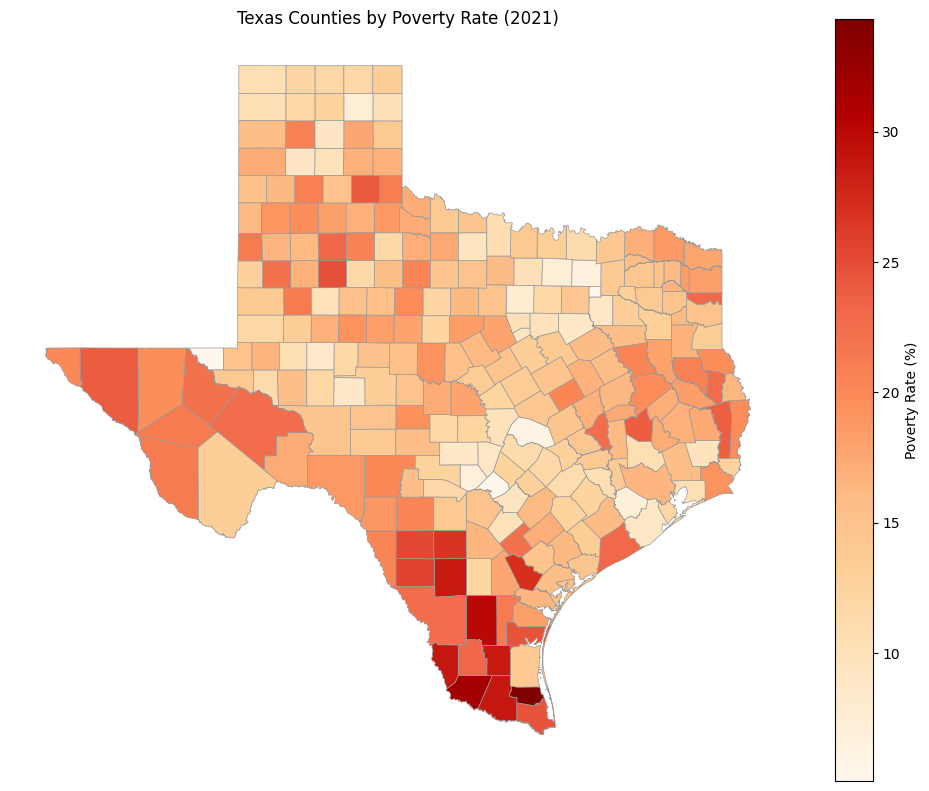


Pearson correlation (Nightlight Diff vs. Poverty Rate): -0.204
p-value: 1.100e-03


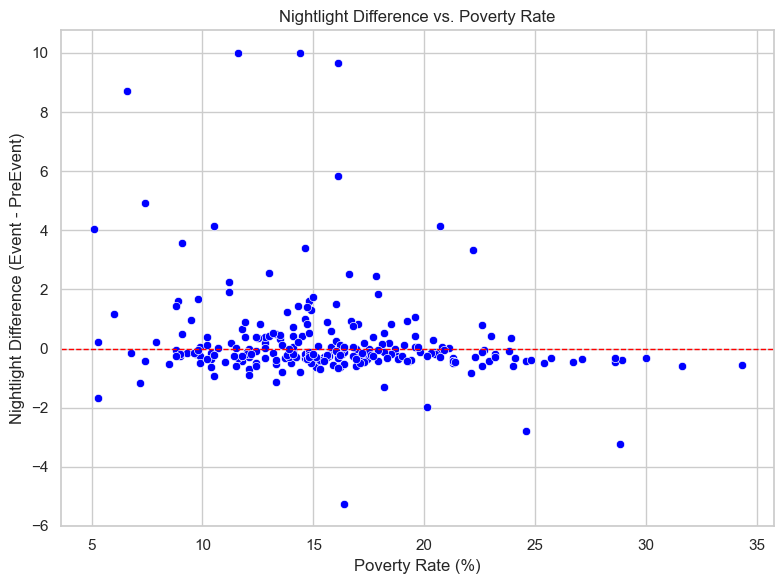

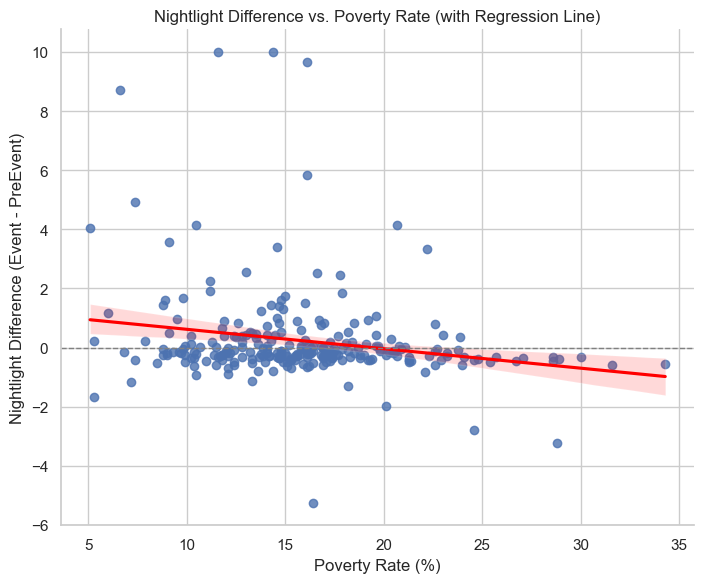


Regression: Difference ~ Poverty Rate
                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     10.90
Date:                Wed, 21 May 2025   Prob (F-statistic):            0.00110
Time:                        15:49:47   Log-Likelihood:                -474.10
No. Observations:                 254   AIC:                             952.2
Df Residuals:                     252   BIC:                             959.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1. Load and Filter Poverty Data
# -------------------------------------------------------------------
# Adjust this path to the actual location of "PovertyEstimates.csv" on your PC:
poverty_df = pd.read_csv(
    r"C:\Users\Shawn\Desktop\noaa trial\assessment\project2\PovertyEstimates.csv"
)

print("Columns in poverty_df:", poverty_df.columns)
print(poverty_df.head(10))  # Peek at first rows to confirm structure

# We want only county-level rows (FIPS_Code != 0) for Texas (Stabr='TX'),
# and specifically the row where Attribute == 'PCTPOVALL_2021' (the % in poverty).
poverty_tx_df = poverty_df[
    (poverty_df['FIPS_Code'] != 0) &
    (poverty_df['Stabr'] == 'TX') &
    (poverty_df['Attribute'] == 'PCTPOVALL_2021')
].copy()

# Ensure FIPS_Code is a 5-digit string (e.g., "48001").
poverty_tx_df['FIPS_Code'] = poverty_tx_df['FIPS_Code'].astype(str).str.zfill(5)

# Rename "Value" to something clearer, e.g. "PovRate"
poverty_tx_df.rename(columns={'Value': 'PovRate'}, inplace=True)

print("\nFiltered poverty data for Texas counties:\n", poverty_tx_df.head())

# -------------------------------------------------------------------
# 2. Merge Poverty Data into Your Counties GeoDataFrame
# -------------------------------------------------------------------
# texas_counties_stats_gdf is your existing GDF with columns "GEOID" and "Difference".
# We'll merge on 'GEOID' (in GDF) and 'FIPS_Code' (in our poverty DataFrame).
texas_counties_stats_gdf = texas_counties_stats_gdf.merge(
    poverty_tx_df[['FIPS_Code', 'PovRate']],   # only need these two columns
    left_on='GEOID',
    right_on='FIPS_Code',
    how='left'
)

print("\nMerged GeoDataFrame columns:\n", texas_counties_stats_gdf.columns)
print(texas_counties_stats_gdf.head())

# -------------------------------------------------------------------
# 3. Map the Poverty Rate by County
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

texas_counties_stats_gdf.plot(
    column='PovRate',         # our newly added poverty column
    cmap='OrRd',
    linewidth=0.5,
    ax=ax,
    edgecolor='0.6',
    legend=True,
    legend_kwds={
        'label': "Poverty Rate (%)",
        'orientation': "vertical"
    },
    missing_kwds={"color": "lightgrey"}
)

ax.set_title('Texas Counties by Poverty Rate (2021)')
ax.axis('off')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 4. Correlation: Nightlight Difference vs. Poverty Rate
# -------------------------------------------------------------------
df_for_corr = texas_counties_stats_gdf.dropna(subset=['Difference', 'PovRate'])
corr, p_value = pearsonr(df_for_corr['Difference'], df_for_corr['PovRate'])

print(f"\nPearson correlation (Nightlight Diff vs. Poverty Rate): {corr:.3f}")
print(f"p-value: {p_value:.3e}")

# -------------------------------------------------------------------
# 5. Scatter + Regression Plot
# -------------------------------------------------------------------
sns.set(style="whitegrid")

# (a) Simple scatter
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_for_corr,
    x='PovRate',
    y='Difference',
    color='blue'
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Nightlight Difference vs. Poverty Rate")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Nightlight Difference (Event - PreEvent)")
plt.tight_layout()
plt.show()

# (b) Scatter with linear regression line
sns.lmplot(
    data=df_for_corr,
    x='PovRate',
    y='Difference',
    height=6,
    aspect=1.2,
    line_kws={'color':'red'}
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Nightlight Difference vs. Poverty Rate (with Regression Line)")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Nightlight Difference (Event - PreEvent)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 6. Simple Linear Regression (OLS)
# -------------------------------------------------------------------
X = df_for_corr[['PovRate']].copy()
X = sm.add_constant(X)  # Add intercept term
y = df_for_corr['Difference']

model = sm.OLS(y, X).fit()
print("\nRegression: Difference ~ Poverty Rate")
print(model.summary())


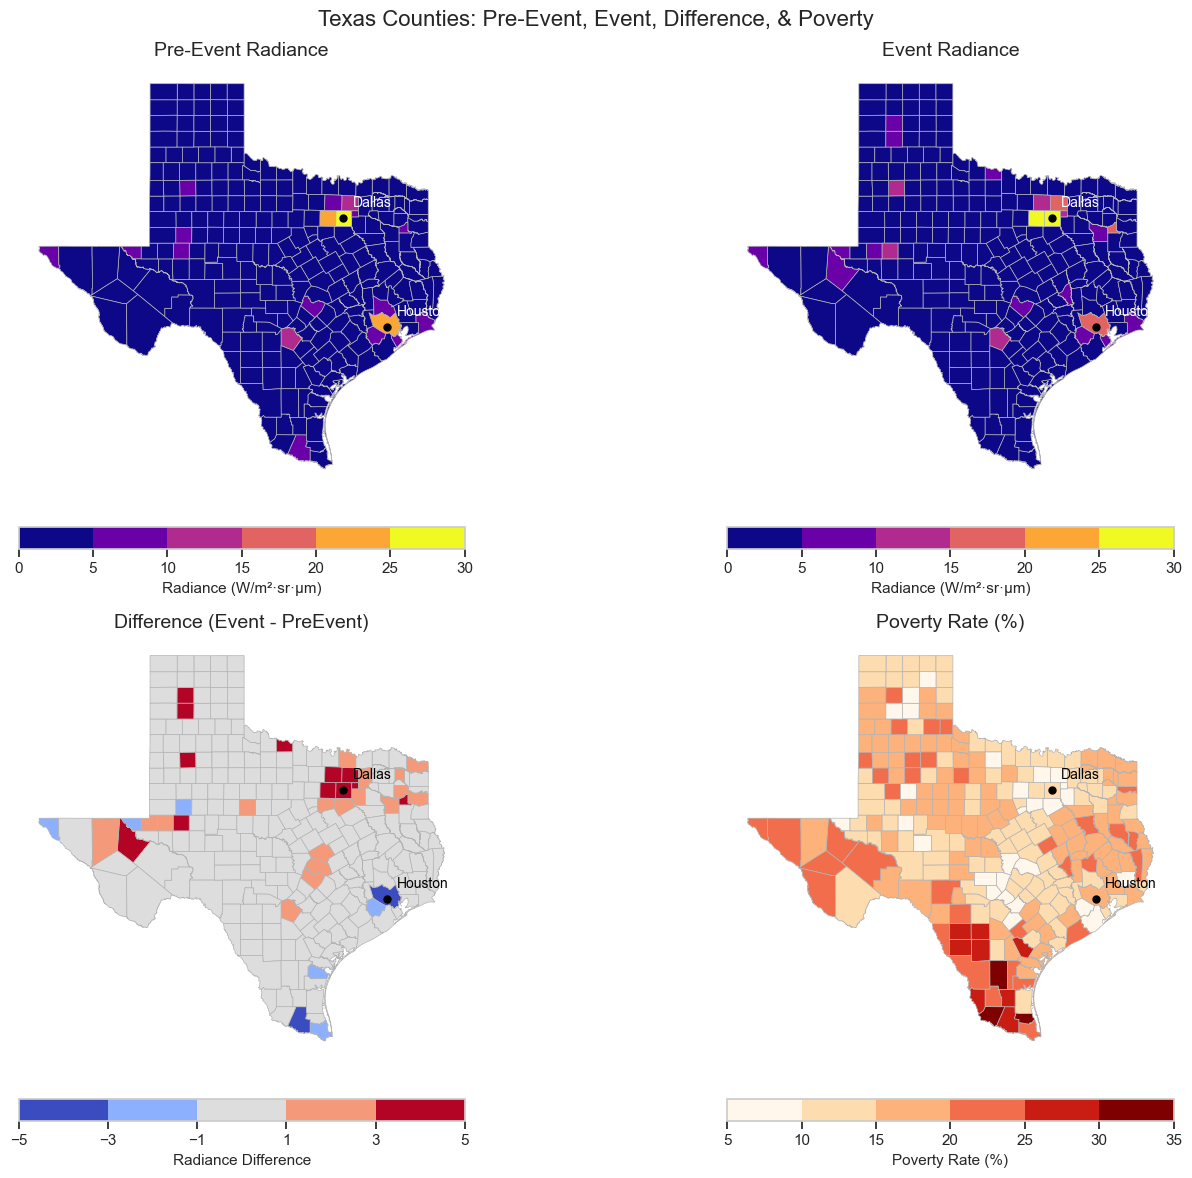

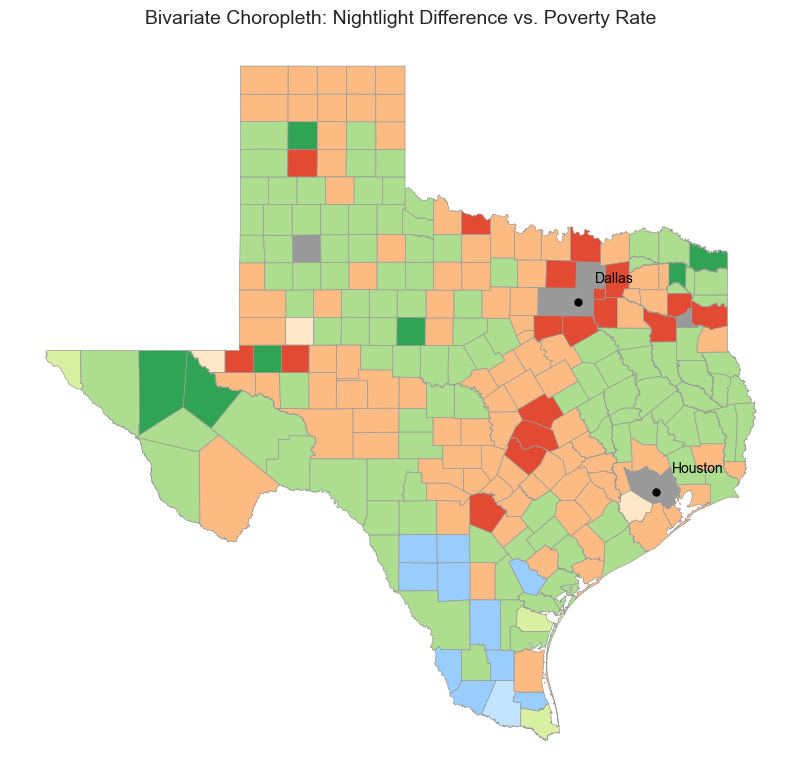

C:\Users\Shawn\AppData\Local\Temp\ipykernel_13412\2466636009.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


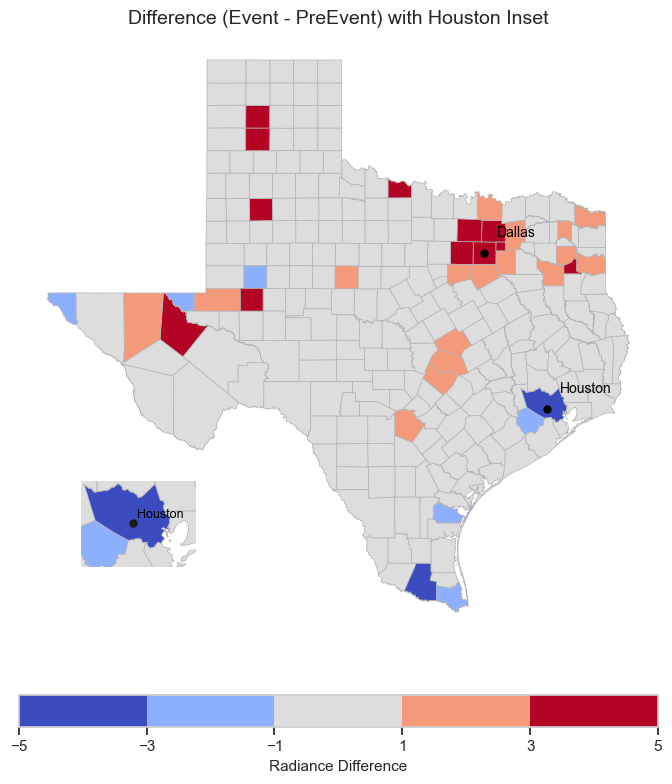

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ----------------------------------------------------------------------------
# Assume you already have:
# texas_counties_stats_gdf with columns:
#   'Pre_Event_mean', 'Event_mean', 'Difference', 'PovRate', 'geometry'
#
# Also assume it's in EPSG:4326 (lat/lon).
# ----------------------------------------------------------------------------

# Let's define some city locations to mark on the maps
cities = {
    'Houston':  (-95.3698, 29.7604),
    'Dallas':   (-96.7970, 32.7767)
}

# Helper function to plot city markers on a given Axes
def plot_city_markers(ax, city_dict, text_color='black'):
    for name, (lon, lat) in city_dict.items():
        ax.plot(lon, lat, marker='o', color='black', markersize=5)
        # Offset the text a bit so it doesn't overlap the marker
        ax.text(lon + 0.3, lat + 0.3, name, color=text_color, fontsize=10)

# ----------------------------------------------------------------------------
# 1. A 2x2 Subplot: (1) Pre-Event Radiance, (2) Event Radiance,
#    (3) Difference, (4) Poverty Rate
#    Each with discrete color intervals & markers for Houston/Dallas
# ----------------------------------------------------------------------------
def plot_four_panel_maps(gdf):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    ax1, ax2, ax3, ax4 = axes.flat

    # --------------------------------------------------
    # (A) Pre-Event Radiance
    # --------------------------------------------------
    # Define bins & colormap
    bins_pre = np.linspace(0, 30, 7)  # Example: 0..30 in 5-6 intervals
    cmap_pre = plt.get_cmap('plasma', len(bins_pre) - 1)
    norm_pre = BoundaryNorm(bins_pre, ncolors=cmap_pre.N)

    im1 = gdf.plot(
        column='Pre_Event_mean',
        cmap=cmap_pre,
        norm=norm_pre,
        linewidth=0.5,
        ax=ax1,
        edgecolor='0.7'
    )
    ax1.set_title("Pre-Event Radiance", fontsize=14)
    ax1.axis('off')
    # Add city markers
    plot_city_markers(ax1, cities, text_color='white')

    # Colorbar
    cbar1 = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm_pre, cmap=cmap_pre),
        ax=ax1,
        orientation='horizontal',
        fraction=0.046,
        pad=0.08,
        ticks=bins_pre
    )
    cbar1.set_label("Radiance (W/m²·sr·µm)", fontsize=11)

    # --------------------------------------------------
    # (B) Event Radiance
    # --------------------------------------------------
    bins_event = np.linspace(0, 30, 7)  # Adjust as needed
    cmap_event = plt.get_cmap('plasma', len(bins_event) - 1)
    norm_event = BoundaryNorm(bins_event, ncolors=cmap_event.N)

    im2 = gdf.plot(
        column='Event_mean',
        cmap=cmap_event,
        norm=norm_event,
        linewidth=0.5,
        ax=ax2,
        edgecolor='0.7'
    )
    ax2.set_title("Event Radiance", fontsize=14)
    ax2.axis('off')
    plot_city_markers(ax2, cities, text_color='white')

    cbar2 = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm_event, cmap=cmap_event),
        ax=ax2,
        orientation='horizontal',
        fraction=0.046,
        pad=0.08,
        ticks=bins_event
    )
    cbar2.set_label("Radiance (W/m²·sr·µm)", fontsize=11)

    # --------------------------------------------------
    # (C) Difference (Event - PreEvent)
    # --------------------------------------------------
    # Example: -5..5 in increments
    bins_diff = np.arange(-5, 6, 2)  # -5, -3, -1, 1, 3, 5
    cmap_diff = plt.get_cmap('coolwarm', len(bins_diff) - 1)
    norm_diff = BoundaryNorm(bins_diff, ncolors=cmap_diff.N)

    im3 = gdf.plot(
        column='Difference',
        cmap=cmap_diff,
        norm=norm_diff,
        linewidth=0.5,
        ax=ax3,
        edgecolor='0.7'
    )
    ax3.set_title("Difference (Event - PreEvent)", fontsize=14)
    ax3.axis('off')
    plot_city_markers(ax3, cities, text_color='black')

    cbar3 = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm_diff, cmap=cmap_diff),
        ax=ax3,
        orientation='horizontal',
        fraction=0.046,
        pad=0.08,
        ticks=bins_diff
    )
    cbar3.set_label("Radiance Difference", fontsize=11)

    # --------------------------------------------------
    # (D) Poverty Rate
    # --------------------------------------------------
    # Suppose range is from 5% to 35% with intervals of 5
    bins_poverty = np.arange(5, 40, 5)  # 5..35
    cmap_pov = plt.get_cmap('OrRd', len(bins_poverty) - 1)
    norm_pov = BoundaryNorm(bins_poverty, ncolors=cmap_pov.N)

    im4 = gdf.plot(
        column='PovRate',
        cmap=cmap_pov,
        norm=norm_pov,
        linewidth=0.5,
        ax=ax4,
        edgecolor='0.7'
    )
    ax4.set_title("Poverty Rate (%)", fontsize=14)
    ax4.axis('off')
    plot_city_markers(ax4, cities, text_color='black')

    cbar4 = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm_pov, cmap=cmap_pov),
        ax=ax4,
        orientation='horizontal',
        fraction=0.046,
        pad=0.08,
        ticks=bins_poverty
    )
    cbar4.set_label("Poverty Rate (%)", fontsize=11)

    fig.suptitle("Texas Counties: Pre-Event, Event, Difference, & Poverty", fontsize=16)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------------
# 2. Bivariate Choropleth: Combining 'Difference' & 'PovRate'
# ----------------------------------------------------------------------------
# We'll divide each variable into 3 classes (low, medium, high).
def plot_bivariate_map(gdf):
    # Step 1: Define bins for difference & poverty
    diff_bins = [-5, -1, 1, 5]   # example: < -1 (low), between -1 and 1 (mid), > 1 (high)
    pov_bins  = [0, 15, 25, 100] # example: <15% (low), 15-25% (med), >25% (high)

    # Classify difference & poverty
    gdf['diff_class'] = pd.cut(gdf['Difference'], bins=diff_bins, labels=['LowDiff','MidDiff','HighDiff'])
    gdf['pov_class']  = pd.cut(gdf['PovRate'], bins=pov_bins, labels=['LowPov','MidPov','HighPov'])

    # Combine into a single bivariate category
    gdf['bivar_cat'] = gdf['diff_class'].astype(str) + "_" + gdf['pov_class'].astype(str)

    # Step 2: Define a color scheme for the 3x3 combos
    # For instance, rows = difference, cols = poverty
    # We'll manually map each combination to a color
    bivar_colors = {
        'LowDiff_LowPov':   '#fee8c8',  # pick a lighter color
        'MidDiff_LowPov':   '#fdbb84',
        'HighDiff_LowPov':  '#e34a33',
        'LowDiff_MidPov':   '#d9f0a3',
        'MidDiff_MidPov':   '#addd8e',
        'HighDiff_MidPov':  '#31a354',
        'LowDiff_HighPov':  '#c2e5ff',
        'MidDiff_HighPov':  '#99ccff',
        'HighDiff_HighPov': '#3399ff'
    }

    # Create a fallback color for missing or out-of-range combos
    def get_bivar_color(cat):
        return bivar_colors.get(cat, "#999999")

    # Step 3: Plot the bivariate map
    fig, ax = plt.subplots(figsize=(10,8))
    gdf['bivar_color'] = gdf['bivar_cat'].apply(get_bivar_color)

    gdf.plot(
        color=gdf['bivar_color'],
        linewidth=0.5,
        edgecolor='0.6',
        ax=ax
    )

    ax.set_title("Bivariate Choropleth: Nightlight Difference vs. Poverty Rate", fontsize=14)
    ax.axis('off')
    plot_city_markers(ax, cities, text_color='black')

    plt.tight_layout()
    plt.show()

    # (Optional) You can create a custom legend square showing each 3×3 category
    # but that's a bit more manual work. 


# ----------------------------------------------------------------------------
# 3. Inset Map Example: Zoom in on Houston
# ----------------------------------------------------------------------------
def plot_inset_map(gdf):
    # We'll do a normal map of Difference for the whole state,
    # then create an inset axis that zooms around Houston area.

    fig, ax = plt.subplots(figsize=(10, 8))

    # 3a: Main map for entire Texas
    bins_diff = np.arange(-5, 6, 2)  # same as before
    cmap_diff = plt.get_cmap('coolwarm', len(bins_diff) - 1)
    norm_diff = BoundaryNorm(bins_diff, ncolors=cmap_diff.N)

    gdf.plot(
        column='Difference',
        cmap=cmap_diff,
        norm=norm_diff,
        linewidth=0.5,
        edgecolor='0.7',
        ax=ax
    )
    ax.set_title("Difference (Event - PreEvent) with Houston Inset", fontsize=14)
    ax.axis('off')
    plot_city_markers(ax, cities, text_color='black')

    # Colorbar on main map
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm_diff, cmap=cmap_diff),
        ax=ax,
        orientation='horizontal',
        fraction=0.046,
        pad=0.08,
        ticks=bins_diff
    )
    cbar.set_label("Radiance Difference", fontsize=11)

    # 3b: Inset for Houston
    # Create an inset axes on top of 'ax'
    axins = inset_axes(ax,
                       width="45%",  # % of parent_axes width
                       height="45%", # % of parent_axes height
                       loc='lower left',
                       bbox_to_anchor=(0.05, 0.05, 0.4, 0.4),
                       bbox_transform=ax.transAxes,
                       borderpad=2
                      )

    # We can define a bounding box around Houston (roughly).
    # For instance, let's say:
    #   lat range ~ (29, 30)
    #   lon range ~ (-96.5, -94.5)
    # Adjust as needed to see the desired region
    axins.set_xlim([-96.0, -94.6])
    axins.set_ylim([29.3, 30.2])

    # Redraw the same polygons in the inset
    gdf.plot(
        column='Difference',
        cmap=cmap_diff,
        norm=norm_diff,
        linewidth=0.5,
        edgecolor='0.7',
        ax=axins
    )

    # Add the city marker for Houston in the inset
    axins.plot(cities['Houston'][0], cities['Houston'][1], 'ko', markersize=5)
    axins.text(cities['Houston'][0] + 0.05, cities['Houston'][1] + 0.05, "Houston", color='black', fontsize=9)

    axins.axis('off')

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------------
# MAIN EXECUTION
# ----------------------------------------------------------------------------
if __name__ == "__main__":

    # 1. Four-panel figure
    plot_four_panel_maps(texas_counties_stats_gdf)

    # 2. Bivariate map
    plot_bivariate_map(texas_counties_stats_gdf)

    # 3. Inset map focusing on Houston
    plot_inset_map(texas_counties_stats_gdf)
